# Search_for_new_pattern.ipynb

In [30]:
#!/usr/bin/env python
'''File name: Search_for_new_pattern.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 16.04.2018
    Date last modified: 16.04.2018

    ############################################################## 
    Purpos:

    Search for the occurance of new, preveously undetected XWTs from IFS in ERA5:
    need to run first - 
    ~/projects/2019_Janice-CA-Fire-WTs/programs/plots/2020_XWTs-IFS/2020_XWTs-IFS.ipynb

    1) Read the IFS daily patterns
    2) Calculate the ERA5 patterns
    3) Search for the most similar days

'''

from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys

from Functions_Extreme_WTs import XWT
from Functions_Extreme_WTs import MRR, MRD, perkins_skill
from Functions_Extreme_WTs import PreprocessWTdata


def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

# ###################################################
# Get the setup for the XWTing
DW_Regions=['San_Diego','LA','Central_Coast','Bay_Area','Northeast','Modoc','Siearas_East','Siearas_West']
SortXWTs = [[0,1],
           [0,1],
           [2,0,1],
           [1,0], #[2,3,1,0]
           [0,3,2,1], #[2,1,0],
           [1,0],
           [1,0,2],
           [2,1,0]]
Season='Annual' # ['AMJJAS', 'ONDJFM']
iReg=7 #int(sys.argv[1])
Region=DW_Regions[iReg]
from XWTs_apply_ERA5 import HUC2_XWTs_apply
rgdTime, iMonths, sPlotDir, sDataDir, sSubregionPR, rgsWTvars, VarsFullName,rgsWTfolders, rgrNrOfExtremes, \
    WT_Domains, DomDegreeAdd, Annual_Cycle, SpatialSmoothing, Metrics, Dimensions,FireObs,REANAL,\
    ClusterMeth, ClusterBreakup, RelAnnom, NormalizeData, MinDistDD, RemoveAnnualCycl= HUC2_XWTs_apply(Season,Region)
# rgrNrOfExtremes = 10

sSubregionPR=sSubregionPR+Region

# create nessesary directories
if not os.path.exists(sDataDir):
    os.makedirs(sDataDir)
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)
sRegion=Region.replace('/','-')

YYYY_stamp=str(rgdTime.year[0])+'-'+str(rgdTime.year[-1])
ss='-'
VarsJoint=ss.join(VarsFullName)
sMonths=ss.join([str(iMonths[ii]) for ii in range(len(iMonths))])
rgiSeasonWT=np.isin(rgdTime.month, iMonths)
rgiYears=np.unique(rgdTime.year)
rgdTime=rgdTime[rgiSeasonWT]
SPLIT=np.where(rgdTime.year < rgiYears[int(np.round(len(rgiYears)/2))])[0][-1]
rgdTimeMM = pd.date_range(datetime.datetime(rgdTime.year[0], rgdTime.month[0], rgdTime.day[0],0), end=datetime.datetime(rgdTime.year[-1], rgdTime.month[-1], rgdTime.day[-1],0), freq='m')

sPlotDir=sPlotDir+sRegion+'/'
if not os.path.exists(sPlotDir):
    os.makedirs(sPlotDir)

print(str(rgrNrOfExtremes)+' EXTREMES')
iNrOfExtremes=rgrNrOfExtremes   # we consider the N highest rainfall extremes

8 EXTREMES


### Read the IFS patterns

In [2]:
# those are saved within the program - ~/projects/2019_Janice-CA-Fire-WTs/programs/plots/2020_XWTs-IFS/2020_XWTs-IFS.ipynb
DATA = np.load('/glade/campaign/mmm/c3we/prein/Papers/2019_Janice-CA-Fire-WTs/data/XWT_IFS/IFS_patterns_'+DW_Regions[iReg]+'.npz')
DailyVarsEvalNorm = DATA['DailyVarsEvalNorm']
IFSLon2D=DATA['IFSLon2D']
IFSLat2D=DATA['IFSLat2D']
IFS_time=DATA['IFS_time']
IFS_time = pd.DatetimeIndex(IFS_time)
TargetTime = np.where(IFS_time == datetime.datetime(2020, 8, 19,0))[0][0]
New_XWT = DailyVarsEvalNorm[TargetTime,:,:,:]

In [4]:
rgdTime = pd.date_range(datetime.datetime(1984, 1, 1,0), end=datetime.datetime(2019, 12, 31,12), freq='d')
# ###################################################
#       READ IN SHAPEFILE
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
ncid.close()
rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
sf = shp.Reader(sSubregionPR)
df = read_shapefile(sf)
for sf in range(df.shape[0]):
    ctr = df['coords'][sf]
    if len(ctr) > 10000:
        ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
    else:
        ctr=np.array(ctr)
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    rgrSRactP[TMP == 1]=1
rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))

DomainSizes=['S','M','L','XXL']
DomDegreeAdd=[2,5,10,20]
DomDelta=DomDegreeAdd[DomainSizes.index(WT_Domains)]

Wlon=ctr[:,0].min()
Elon=ctr[:,0].max()
Nlat=ctr[:,1].max()
Slat=ctr[:,1].min()

DomainWT=np.array([[Elon+DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Slat-DomDelta],
                   [Wlon-DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Nlat+DomDelta],
                   [Elon+DomDelta,Slat-DomDelta]])
grWTregion=mplPath.Path(DomainWT)


# ###################################################
#         Read the ERA-5 grid and data
    
from Functions_Extreme_WTs import ReadERA5
DailyVarsOrig, LonWT, LatWT=ReadERA5(grWTregion,        # shapefile with WTing region
                                     rgdTime,           # time period for WTing
                                     iMonths,           # list of months that should be considered
                                     rgsWTfolders,      # directories containing WT files
                                     rgsWTvars)         # netcdf variable names of WT variables

# run split sample thest and derive centroids of full dataset
Samples=['SS1',"SS2","Full"]
grClustersFin={}
grEucledianDist={}
grCorrelation={}
grPSS={}
grMRD={}
grMRR={}
grExluded={}
grAPR={}
for ss in [2]: #range(len(Samples)):
    print('    Split Sample '+Samples[ss])
    if ss == 0:
        DailyVarsTrain=DailyVarsOrig[:SPLIT,:]
        DailyVarsEval=DailyVarsOrig[-SPLIT:,:]
#         Ptrain=rgrPRrecords[:SPLIT]
#         Peval=rgrPRrecords[-SPLIT:]
        TimeTrain=rgdTime[:SPLIT]
        TimeEval=rgdTime[-SPLIT:]
    elif ss == 1:
        DailyVarsTrain=DailyVarsOrig[-SPLIT:,:]
        DailyVarsEval=DailyVarsOrig[:SPLIT,:]
#         Ptrain=rgrPRrecords[-SPLIT:]
#         Peval=rgrPRrecords[:SPLIT]
        TimeTrain=rgdTime[-SPLIT:]
        TimeEval=rgdTime[:SPLIT]
    elif ss == 2:
        DailyVarsTrain=DailyVarsOrig
        DailyVarsEval=DailyVarsOrig
#         Ptrain=rgrPRrecords
#         Peval=rgrPRrecords
        TimeTrain=rgdTime
        TimeEval=rgdTime

        

        Read ERA-5 year: 1984
        Read ERA-5 year: 1985
        Read ERA-5 year: 1986
        Read ERA-5 year: 1987
        Read ERA-5 year: 1988
        Read ERA-5 year: 1989
        Read ERA-5 year: 1990
        Read ERA-5 year: 1991
        Read ERA-5 year: 1992
        Read ERA-5 year: 1993
        Read ERA-5 year: 1994
        Read ERA-5 year: 1995
        Read ERA-5 year: 1996
        Read ERA-5 year: 1997
        Read ERA-5 year: 1998
        Read ERA-5 year: 1999
        Read ERA-5 year: 2000
        Read ERA-5 year: 2001
        Read ERA-5 year: 2002
        Read ERA-5 year: 2003
        Read ERA-5 year: 2004
        Read ERA-5 year: 2005
        Read ERA-5 year: 2006
        Read ERA-5 year: 2007
        Read ERA-5 year: 2008
        Read ERA-5 year: 2009
        Read ERA-5 year: 2010
        Read ERA-5 year: 2011
        Read ERA-5 year: 2012
        Read ERA-5 year: 2013
        Read ERA-5 year: 2014
        Read ERA-5 year: 2015
        Read ERA-5 year: 2016
        Re

In [23]:
# ---------
# Setup clustering algorithm
ClusterMeth='hdbscan'  # current options are ['HandK','hdbscan']
ClusterBreakup = 0     # breakes up clusters that are unproportionally large (only for hdbscan)
RelAnnom=1             # 1 - calculates daily relative anomalies
NormalizeData='D'      # normalize variables | options are  - 'C' - climatology
                                                        # - 'D' - daily (default)
                                                        # - 'N' - none
MinDistDD=7            # minimum nr of days between XWT events
RemoveAnnualCycl=1     # remove annual cycle in varaiables with 21 day moving average filter
# ---------


DailyVarsEvalNorm= PreprocessWTdata(DailyVarsTrain,               # WT data [time,lat,lon,var]
                   RelAnnom=RelAnnom,                     # calculate relative anomalies [1-yes; 0-no]
                   SmoothSigma=SpatialSmoothing,   # Smoothing stddev (Gaussian smoothing)
                   RemoveAnnualCycl=RemoveAnnualCycl,             # remove annual cycle [1-yes; 0-no]
                   NormalizeData=NormalizeData)                # normalize data [1-yes; 0-no]

### Search minimum ED

In [24]:
SHAPE=DailyVarsEvalNorm.shape
Data_flatten=np.reshape(DailyVarsEvalNorm, (SHAPE[0],SHAPE[1]*SHAPE[2]*SHAPE[3]))
New_XWT_reshaped = np.reshape(New_XWT, (SHAPE[1]*SHAPE[2]*SHAPE[3]))[None,:]
EucledianDist=np.zeros((SHAPE[0],New_XWT_reshaped.shape[0])); EucledianDist[:]=np.nan
Correlation=np.copy(EucledianDist)
for dd in range(SHAPE[0]):
    EucledianDist[dd,:] = np.array([np.linalg.norm(New_XWT_reshaped[wt,:]-Data_flatten[dd,:]) for wt in range(New_XWT_reshaped.shape[0])])
    Correlation[dd,:] = np.array([np.corrcoef(New_XWT_reshaped[wt,:],Data_flatten[dd,:])[0][1] for wt in range(New_XWT_reshaped.shape[0])])


In [25]:
rgdTime[np.argsort(EucledianDist.flatten())[:10]]

DatetimeIndex(['2018-07-09', '1990-10-17', '2014-10-09', '2014-10-08',
               '2014-05-26', '1996-10-17', '2018-07-26', '1985-07-10',
               '2001-06-07', '2016-06-27'],
              dtype='datetime64[ns]', freq=None)

### Read MTBS_CA_1984_2016.csv

In [9]:
CA_Regions = DW_Regions
StartTime=datetime.datetime(1984, 1, 1)  #Y-M-D --> days are smallest possible period
StopTime=datetime.datetime(2016, 12, 31)
rgdTimeMTBS = pd.date_range(StartTime, end=StopTime, freq='d')
rgiYearsMTPS=np.unique(rgdTimeMTBS.year)

sFireData='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/data/MTBS_CA_1984_2016.csv'
sSaveDataDir='/glade/work/prein/projects/2019_Janice-CA-Fire-WTs/data/'

DATA=pd.read_csv(sFireData)
Keys=DATA.keys()
lat=np.array(DATA['lat16'])
lon=np.array(DATA['lon16'])
YYYY=np.array(DATA['FIRE_YEAR'])
MM=np.array(DATA['FIRE_MON'])
DD=np.array(DATA['FIRE_DAY'])
FireID=np.array(DATA['FIRE_ID'])
AcresBurned=np.array(DATA['R_ACRES'])*0.00404686

MTBS_SRdata=np.zeros((len(rgdTimeMTBS),len(CA_Regions))); MTBS_SRdata[:]=0
for sr in [iReg]: #range(len(CA_Regions)):
    print('    process MTBS data for region '+CA_Regions[sr])
    sSubregionPR='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/'+CA_Regions[sr]

    rgrGridCells=[(lon.ravel()[ii],lat.ravel()[ii]) for ii in range(len(lon.ravel()))]
    rgrSRactP=np.zeros((lon.shape[0]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        rgrSRactP[TMP == 1]=1
    LONact=lon[rgrSRactP == 1]
    LATact=lat[rgrSRactP == 1]
    BURNEDact=AcresBurned[rgrSRactP == 1]
    MMact=MM[rgrSRactP == 1]
    YYYYact=YYYY[rgrSRactP == 1]
    DDact=DD[rgrSRactP == 1]
    for fi in range(len(YYYYact)):
        DDid=((rgdTimeMTBS.year == YYYYact[fi]) & (rgdTimeMTBS.month == MMact[fi]) & (rgdTimeMTBS.day == DDact[fi]))
        MTBS_SRdata[DDid,sr]=BURNEDact[fi]

    process MTBS data for region Bay_Area


In [28]:
rgdTimeMTBS[np.argsort(MTBS_SRdata[:,3])[-20:]]

DatetimeIndex(['2008-06-21', '2016-09-26', '2000-06-13', '2003-08-27',
               '1988-09-18', '2016-08-03', '2006-07-11', '2003-07-20',
               '2005-07-19', '1984-06-28', '2014-07-05', '2003-06-01',
               '2009-08-12', '2015-07-22', '1985-07-07', '2009-08-13',
               '1995-10-03', '1988-09-17', '2006-07-09', '2007-09-03'],
              dtype='datetime64[ns]', freq=None)

In [29]:
rgdTime[np.argsort(EucledianDist.flatten())[:20]]

DatetimeIndex(['2018-07-09', '1990-10-17', '2014-10-09', '2014-10-08',
               '2014-05-26', '1996-10-17', '2018-07-26', '1985-07-10',
               '2001-06-07', '2016-06-27', '2008-05-02', '2009-05-11',
               '1990-04-13', '2013-03-24', '1994-06-08', '2008-06-18',
               '2018-08-05', '2018-08-06', '2014-10-10', '2018-11-04'],
              dtype='datetime64[ns]', freq=None)

In [89]:
# FocusFire=datetime.datetime(1985, 7, 10) # Northern California Lightning Siege
FocusFire=datetime.datetime(2018,7,9)

### Plot the conditions on the focus day

In [90]:
rgiExtremeDays = [FocusFire]
# #############################################################################
# ######             PLOT THE CENTROIDS

from Functions_Extreme_WTs import add_subplot_axes

if (DW_Regions[iReg] == 'Modoc') | (DW_Regions[iReg] == 'Northeast') | (DW_Regions[iReg] == 'Siearas_East') | (DW_Regions[iReg] == 'Siearas_West'):
    rgsWTvarsA=['Z500','U500','V500','CAPE','MR850']
    rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA5/Z500/Z500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/U500/U500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/V500/V500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/CAPE/CAPE_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/MR850/MR850']
else:
    rgsWTvarsA=['Z500','U850','V850','CAPE','MR850']
    rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA5/Z500/Z500_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/U850/U850_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/V850/V850_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/CAPE/CAPE_',\
                  '/glade/campaign/mmm/c3we/prein/ERA5/MR850/MR850']

DW_Regions=['San_Diego','LA','Central_Coast','Bay_Area','Northeast','Modoc','Siearas_East','Siearas_West']

# rgsWTvarsA=['Z500','U10AVG','V10AVG','CAPE','MR2AVG']
# rgsWTfoldersA=['/glade/campaign/mmm/c3we/prein/ERA5/Z500/Z500_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/U10AVG/U10AVG_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/V10AVG/V10AVG_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/CAPE/CAPE_',\
#               '/glade/campaign/mmm/c3we/prein/ERA5/MR2AVG/MR2AVG_']
# start reading in the precipitation from PRISM for a larger region
iRegionPlus=70 # grid cell added around shape rectangle
ncid=Dataset('/glade/campaign/mmm/c3we/prein/ERA5/U850/U850_2006.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['latitude'][:])
rgrLonWT1D=np.squeeze(ncid.variables['longitude'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()
rgrGridCells=[(rgrLonWT.ravel()[ii],rgrLatWT.ravel()[ii]) for ii in range(len(rgrLonWT.ravel()))]
rgrSRact=np.array(grWTregion.contains_points(rgrGridCells)); rgrSRact=np.reshape(rgrSRact, (rgrLatWT.shape[0], rgrLatWT.shape[1]))
rgiSrWT=np.array(np.where(rgrSRact == True))
iLatMax=rgiSrWT[0,:].max()+iRegionPlus
iLatMin=rgiSrWT[0,:].min()-iRegionPlus
iLonMax=rgiSrWT[1,:].max()+iRegionPlus
iLonMin=rgiSrWT[1,:].min()-iRegionPlus
rgrLatWT_SR=rgrLatWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrLonWT_SR=rgrLonWT[iLatMin:iLatMax,iLonMin:iLonMax]
rgrWTdata=np.zeros((len(rgiExtremeDays),iLatMax-iLatMin,iLonMax-iLonMin,len(rgsWTvarsA))); rgrWTdata[:]=np.nan

for dd in range(len(rgiExtremeDays)):
    rgdTimeYY = pd.date_range(datetime.datetime(rgiExtremeDays[dd].year, 1, 1,0), end=datetime.datetime(rgiExtremeDays[dd].year, 12, 31,23), freq='d')
    rgiDD=np.where(((rgdTimeYY.year == rgiExtremeDays[dd].year) & (rgdTimeYY.month ==rgiExtremeDays[dd].month ) & (rgdTimeYY.day == rgiExtremeDays[dd].day)))[0]
    for va in range(len(rgsWTvarsA)):
        FILE = glob.glob(rgsWTfoldersA[va]+'*'+str(rgiExtremeDays[dd].year)+'.nc')[0]
        ncid=Dataset(FILE, mode='r')
        rgrWTdata[dd,:,:,va]=np.squeeze(ncid.variables[rgsWTvarsA[va]][rgiDD[0],iLatMin:iLatMax,iLonMin:iLonMax])
        ncid.close()
# # average over the WTs
# rgrWTcentroids=np.zeros((rgrClustersFin[1].max()+1,rgrWTdata.shape[1],rgrWTdata.shape[2],rgrWTdata.shape[3])); rgrWTcentroids[:]=np.nan
# for cc in range(rgrClustersFin[1].max()+1):
#     rgiClAct=(rgrClustersFin[1] == (cc))
#     rgrWTcentroids[cc,:]=np.mean(rgrWTdata[rgiClAct,:,:,:], axis=0)


# # Calculate the geometry of the plot dependent on how many panels there are
# PanWidth=4 # cm
# PanHeight=2.5 # cm
# xdist=0.5
# ydist=0.5
# Panels=rgrClustersFin[1].max()+1
# iColums=np.min([4,Panels])
# iRows=np.max([1,int((math.ceil(Panels/4.)))])
# iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
# iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]

# X_Fig=PanWidth*iColums+xdist*(iColums+1)
# Y_Fig=PanHeight*iRows+(iRows+1)

        Plot map to: /glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/plots/WT-Centroids/Bay_Area/XWT-Days/2018-07-09_Bay_Area_new-XWT.png


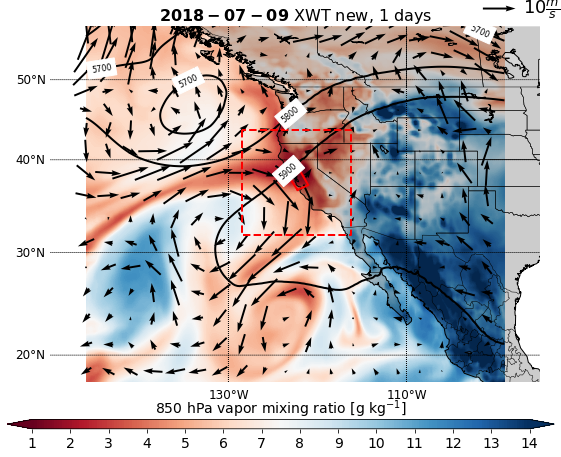

In [91]:
import math
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
PanWidth=4 # cm
PanHeight=2.5 # cm
xdist=0.5
ydist=0.5
Panels=1
iColums=np.min([4,Panels])
iRows=np.max([1,int((math.ceil(Panels/4.)))])
iXX=[0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]
iYY=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
X_Fig=PanWidth*iColums+xdist*(1)
Y_Fig=PanHeight*iRows+(1)
for dd in range(rgrWTdata.shape[0]):
    Date = rgiExtremeDays[dd]
    iXWT = ' new'
    
    plt.rcParams.update({'font.size': 18})
    rgsLableABC=list(string.ascii_lowercase)
    fig = plt.figure(figsize=(8,6.5))
    gs1 = gridspec.GridSpec(1,1)
    gs1.update(left=0.10, right=0.95,
               bottom=0.18, top=0.94,
               wspace=0.05, hspace=0.20)
    # rllcrnrlat,urcrnrlat,llcrnrlon,urcrnrlon=np.min(rgrLatPR_SR),np.max(rgrLatPR_SR),np.min(rgrLatPR_SR),np.max(rgrLatPR_SR)
    dLat=((52-25)/2.)*1.5
    dLon=(130-75)/2.
    rllcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))-dLat #      25 #rllcrnrlat-(urcrnrlat-rllcrnrlat)*0.03
    urcrnrlat=np.mean((rgrLatWT_SR.min(),rgrLatWT_SR.max()))+dLat      #52 #urcrnrlat+(urcrnrlat-rllcrnrlat)*0.01
    llcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))-dLon #    -130 #llcrnrlon-abs(llcrnrlon-urcrnrlon)*0.01
    urcrnrlon=np.mean((rgrLonWT_SR.min(),rgrLonWT_SR.max()))+dLon #     -75 #urcrnrlon+abs(llcrnrlon-urcrnrlon)*0.01

    # define margins of subplot (see http://matplotlib.org/users/gridspec.html)
    iSampleSize=1
    ax = plt.subplot(gs1[0,0])
    try:
        m = Basemap(projection='cea',\
                    llcrnrlat= rllcrnrlat ,urcrnrlat=urcrnrlat,\
                    llcrnrlon=llcrnrlon,urcrnrlon=urcrnrlon,resolution='l', fix_aspect=False)
    except:
        stop()
    plt.axis('off')
    xi, yi = m(rgrLonWT_SR, rgrLatWT_SR)
    rgrColorTable=['#a50026','#d73027','#f46d43','#fdae61','#fee090','#ffffff','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695'][::-1]

    # plot IVT
    biasContDist=10
    iContNr=len(rgrColorTable)+1
    clevs=np.linspace(1, 14,200)
    rgrDataAct=rgrWTdata[dd, :,:,rgsWTvarsA.index('MR850')]*1000.
    cs = m.contourf(xi,yi,rgrDataAct,clevs,cmap='RdBu', extend='both', alpha=1, zlevel=20)
    # plot wind field
    iLev=1; iDist=10
    Q = plt.quiver(xi[::iDist, ::iDist],yi[::iDist, ::iDist],rgrWTdata[dd,::iDist,::iDist,1],
                   rgrWTdata[dd,::iDist,::iDist,2], units='width',zorder = 2, pivot='middle',width=0.004, scale=150)
    qk = ax.quiverkey(Q, 0.95, 1.05, 10, r'$10 \frac{m}{s}$', labelpos='E') #,coordinates='figure')
    # plot geopotential height
    iContNr=20
    clevs=np.arange(0,10000,100)
    CS=m.contour(xi[:,:],yi[:,:],rgrWTdata[dd,:,:,rgsWTvarsA.index('Z500')]/9.81,levels=clevs.astype('int'),
                 colors='k',linewidths=2) #['#d9f0a3','#addd8e','#78c679','#41ab5d','#238443','#005a32'])
    clabels=plt.clabel(CS, inline=1, fontsize=8, fmt='%d')
    [txt.set_backgroundcolor('white') for txt in clabels]
    # plot cluster region
    iLatMax=rgrLatWT1D[rgiSrWT[0,:].max()]
    iLatMin=rgrLatWT1D[rgiSrWT[0,:].min()]
    iLonMax=rgrLonWT1D[rgiSrWT[1,:].max()]
    iLonMin=rgrLonWT1D[rgiSrWT[1,:].min()]
    lats = [iLatMin, iLatMax, iLatMax, iLatMin,iLatMin]
    lons = np.array([iLonMin, iLonMin, iLonMax, iLonMax, iLonMin])-360
    x, y = m(lons,lats)
    m.plot(x,y, lw=2, ls='--', c='r')

    # Lable the map
    plt.title(r"$\bf{" + str(Date)[:10] + "}$"' XWT'+str(iXWT)+', '+str(iSampleSize)+' days', fontsize=16)

    m.drawcoastlines(color='k')
    m.drawcountries(color='k')
    m.drawstates(color='k')
    m.fillcontinents(color='k',lake_color='white', alpha=0.2)
    # add shapefile of catchment
    XX,YY=m(ctr[:,0], ctr[:,1])
    m.plot(XX,YY, c='r', lw=2)

    parallels = np.arange(0.,81,10.)
    # labels = [left,right,top,bottom]
    m.drawparallels(parallels,labels=[True,False,True,False], fontsize=12)
    meridians = np.arange(10.,351.,20.)
    m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=12)

    # add colorbar for IVT
    CbarAx = axes([0.025, 0.08, 0.95, 0.02])
    cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='max', ticks=np.arange(1,21,1))
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_title('850 hPa vapor mixing ratio [g kg$^{-1}$]', fontsize=14)

    # Save the plot
    # plt.show()
    sPlotFile=sPlotDir+'XWT-Days/'
    # sPlotName= 'BottomUp-'+str(rgrClustersFin[1].max()+1)+'WT_Centroids.pdf'
    sPlotName= str(Date)[:10]+'_'+DW_Regions[iReg]+'_new-XWT.png'
    if os.path.isdir(sPlotFile) != 1:
        subprocess.call(["mkdir","-p",sPlotFile])
    print('        Plot map to: '+sPlotFile+sPlotName)
    fig.savefig(sPlotFile+sPlotName, dpi=150)

In [93]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_2016_01_gridded.nc', mode='r') # open the netcdf file
rgrLatPR=np.squeeze(ncid.variables['rlat'][:])
rgrLonPR=np.squeeze(ncid.variables['rlon'][:])
ncid.close()

dStartDayPR=datetime.datetime(2001, 1, 1,0) # (2000, 11, 01,0)
dStopDayPR=datetime.datetime(2019, 11, 30,23)
rgdTimeMODIS = pd.date_range(dStartDayPR, end=dStopDayPR, freq='d')
rgdTimeMM = pd.date_range(dStartDayPR, end=dStopDayPR, freq='m')

MODIS_SRdata=np.zeros((len(rgdTimeMODIS),len(CA_Regions))); MODIS_SRdata[:]=np.nan

for sr in [iReg]: #range(len(CA_Regions)):
    print('    process MODIS for region '+CA_Regions[sr])
    sSubregionPR='/glade/u/home/prein/projects/2019_Janice-CA-Fire-WTs/Shapefiles/'+CA_Regions[sr]

    rgrGridCells=[(rgrLonPR.ravel()[ii],rgrLatPR.ravel()[ii]) for ii in range(len(rgrLonPR.ravel()))]
    rgrSRactP=np.zeros((rgrLonPR.shape[0]*rgrLonPR.shape[1]))
    sf = shp.Reader(sSubregionPR)
    df = read_shapefile(sf)
    for sf in range(df.shape[0]):
        ctr = df['coords'][sf]
        if len(ctr) > 10000:
            ctr=np.array(ctr)[::100,:] # carsen the shapefile accuracy
        else:
            ctr=np.array(ctr)
        grPRregion=mplPath.Path(ctr)
        TMP=np.array(grPRregion.contains_points(rgrGridCells))
        rgrSRactP[TMP == 1]=1
    rgrSRactP=np.reshape(rgrSRactP, (rgrLatPR.shape[0], rgrLatPR.shape[1]))
    
    rgiSrPR=np.array(np.where(rgrSRactP == True))
    iLatMaxP=rgiSrPR[0,:].max()+1
    iLatMinP=rgiSrPR[0,:].min()
    iLonMaxP=rgiSrPR[1,:].max()+1
    iLonMinP=rgiSrPR[1,:].min()
    rgrPRdata=np.zeros((len(rgdTimeMODIS),iLatMaxP-iLatMinP,iLonMaxP-iLonMinP))

    for mo in range(len(rgdTimeMM)):
        rgiDD=np.where(((rgdTimeMM.year[mo] == rgdTimeMODIS.year) & (rgdTimeMODIS.month == rgdTimeMM.month[mo]) & np.isin(rgdTimeMM.month[mo], iMonths)))[0]
        ncid=Dataset('/glade/campaign/mmm/c3we/prein/observations/Fire-observations/Fire_GWIS/data_20020702/GriddedData/MODIS_BA_GLOBAL_1_'+str(rgdTimeMM.year[mo])+'_'+str("%02d" % rgdTimeMM.month[mo])+'_gridded.nc', mode='r')
        rgrPRdata[rgiDD,:,:]=np.squeeze(ncid.variables['BurnedArea'][:,iLatMinP:iLatMaxP,iLonMinP:iLonMaxP])
        ncid.close()
    rgrPRdata[rgrPRdata<0] = np.nan
    MODIS_SRdata[:,sr]=np.nansum(rgrPRdata, axis = (1,2))

    process MODIS for region Bay_Area


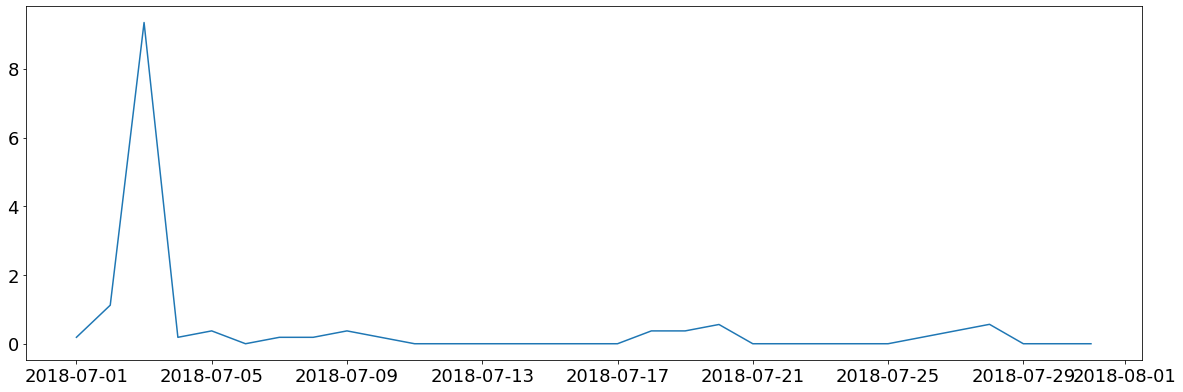

In [101]:
fig = plt.figure(figsize=(20,6.5))
ddFoc = ((rgdTimeMODIS.year == 2018) & (rgdTimeMODIS.month == 7))
plt.plot(rgdTimeMODIS[ddFoc],MODIS_SRdata[ddFoc,iReg])